In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input, multiply
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import os
import sys
sys.path.append('/Users/tradergllc/github/tensorflow/src/')
# sys.path.append('/home/albert/github/tensorflow/src/')
import triplet_merge_cam
import dense

### Mine Triplets

In [3]:
# CAFFE_ROOT = '/home/albert/caffe/'
CAFFE_ROOT = '/Users/tradergllc/github/tensorflow/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [5]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

### Train Network

In [6]:
train_score = {}
test_score = {}

steps_per_epoch = 100

input_shape = (256,128)

overlay = True
overlay_eval = True
preprocess = True

file_root = 'densenet_triplet_cam'

In [7]:
if os.path.exists('/Users/tradergllc/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /Users/tradergllc/github/tensorflow/models/%s' % file_root)

False
False
0.929203033447


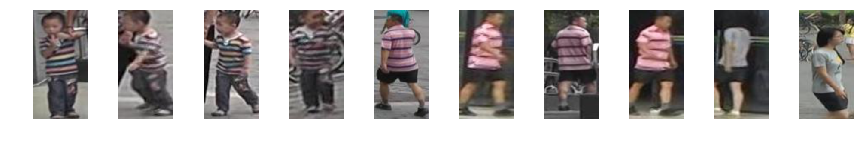

In [8]:
start = time.time()
batch = triplet_merge_cam.output_batch_generator(train_dict, train_labels,
                                                 overlay=False, preprocess=False,
                                                 shape=input_shape).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

False
True
1.21341705322


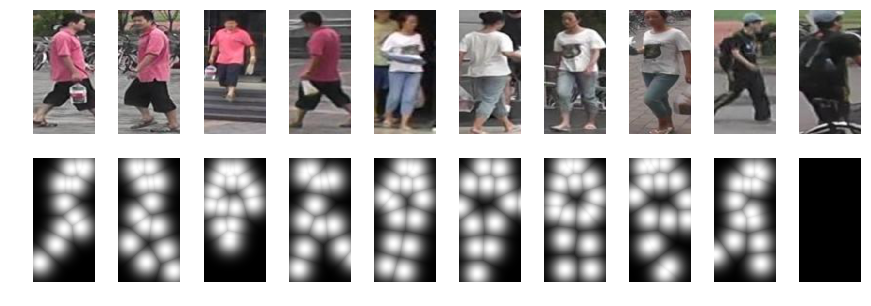

In [9]:
start = time.time()
batch_overlay = triplet_merge_cam.output_batch_generator(train_dict, train_labels,
                                                         overlay=True, preprocess=False,
                                                         shape=input_shape, r=0.35).next()
print time.time() - start

plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,10,i + 1)
    plt.imshow(batch_overlay[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
    plt.subplot(2,10,i + 1 + 10)
    plt.imshow((batch_overlay[0]['input_cam'][i] * 255).astype(np.uint8), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

In [10]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

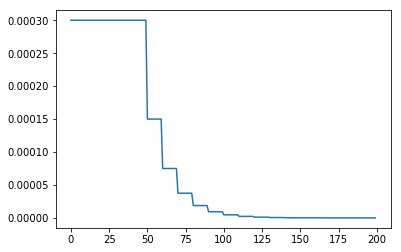

In [11]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [12]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [16]:
trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), cam_placement=[0,1,2,3])
trinet.compile(loss=triplet_merge_cam.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

Weights for the model were loaded successfully


In [17]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_121 (Conv2D)              (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_123 (BatchNo (None, 128, 64, 64)   256         conv2d_121[0][0]                 
____________________________________________________________________________________________________
activation_123 (Activation)      (None, 128, 64, 64)   0           batch_normalization_123[0][0]    
___________________________________________________________________________________________

In [18]:
trinet.save('test.h5')

In [14]:
((4), (2))

(4, 2)

In [14]:
history = History()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet_merge_cam.output_batch_generator(train_dict, train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet_merge_cam.get_score(trinet, train_dict, train_files, hist=history, 
                                                          overlay=overlay, train=True, preprocess=preprocess,
                                                          shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet_merge_cam.get_score(trinet, test_dict, test_files, hist=history, 
                                                         overlay=overlay, train=False, preprocess=preprocess,
                                                         shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

True
True
Epoch 1/10
100/100 [==============================] - 76s - loss: 293.0195    
Epoch 2/10
100/100 [==============================] - 76s - loss: 219.4766    
Epoch 3/10
100/100 [==============================] - 76s - loss: 220.9339    
Epoch 4/10
100/100 [==============================] - 75s - loss: 195.2005    
Epoch 5/10
100/100 [==============================] - 75s - loss: 180.3081    
Epoch 6/10
100/100 [==============================] - 75s - loss: 141.6951    
Epoch 7/10
100/100 [==============================] - 74s - loss: 151.0517    
Epoch 8/10
100/100 [==============================] - 75s - loss: 129.6315    
Epoch 9/10
100/100 [==============================] - 74s - loss: 110.7194    
Epoch 10/10
100/100 [==============================] - 74s - loss: 147.4959    


AttributeError: 'NoneType' object has no attribute 'update'

In [16]:
trinet.save('test.h5')

AttributeError: 'NoneType' object has no attribute 'update'

In [12]:
trinet = load_model('test.h5', custom_objects={'triplet_loss' : triplet_merge_cam.triplet_loss})

preprocess True
overlay False
train True
1000 21.6909160614
2000 41.4988200665
3000 61.3549640179
4000 81.2811591625
5000 100.992001057
6000 120.870461226
7000 140.550979137
8000 160.544087172
9000 180.391611099
10000 200.208063126
11000 220.054560184
12000 240.129014015
train


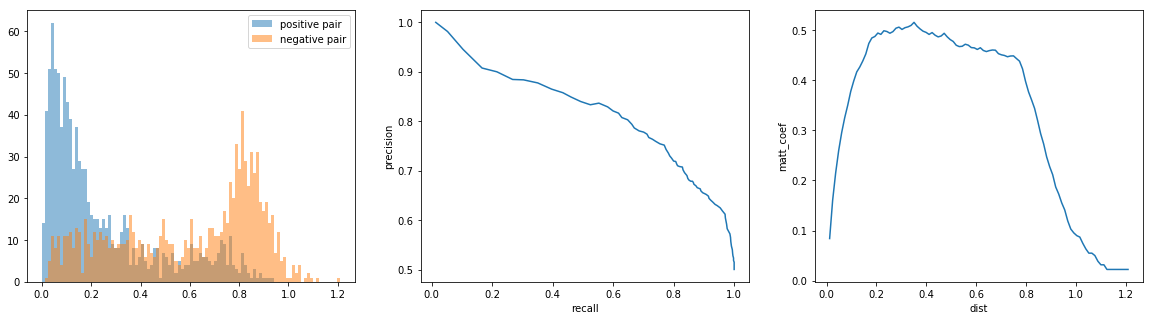

{1: 0.40966666666666668, 20: 0.77166666666666683, 5: 0.60966666666666669}
preprocess True
overlay False
train False
1000 19.6950099468
2000 39.4354398251
3000 59.5578260422
4000 79.1951899529
5000 98.8174638748
6000 118.39888382
7000 138.023278952
8000 157.722569942
9000 177.359100819
10000 196.931381941
11000 216.537521839
12000 236.103675842
13000 255.659211874
test


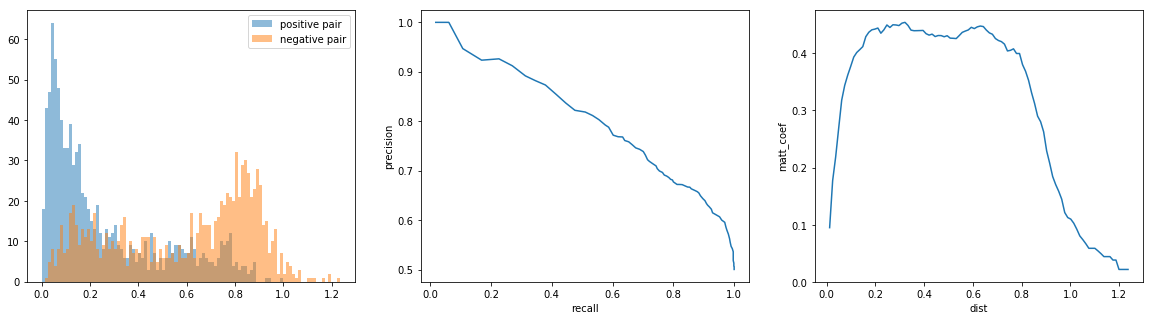

{1: 0.41899999999999998, 20: 0.7553333333333333, 5: 0.60866666666666669}


In [13]:
train_score = triplet_merge_cam.get_score(trinet, train_dict, train_files, hist=None, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                           shape=input_shape)
print 'train'
plot_score(train_score)

test_score = triplet_merge_cam.get_score(trinet, test_dict, test_files, hist=None, 
                                    overlay=overlay_eval, train=False, preprocess=preprocess, 
                                           shape=input_shape)
print 'test'
plot_score(test_score)

In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

### Evaluation

In [ ]:
weights_path = 

trinet_drop_cam = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shapetrinet3), weigtrinetne)
trinet_drop_cam.load_weights(weights_path, by_name=True)

In [ ]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

iterations = 15000

for it in range(1000,iterations + 1000,1000):
    train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][1])))
    train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][5])))
    train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][20])))
    test_rank1_avg.append(np.average(np.array(test_score[it]['rank'][1])))
    test_rank5_avg.append(np.average(np.array(test_score[it]['rank'][5])))
    test_rank20_avg.append(np.average(np.array(test_score[it]['rank'][20])))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(0.4,1.0)
plt.show()

In [ ]:
loss = []
for it in range(1000,iterations + 1000,1000):
    loss += train_score[it]['loss']
plt.plot(loss)